# Crop Recommendation & Automatic Irrigation

This notebook contains the codes & results for the crop recommendation and intelligent irrigation system data exploration & model experimentation, and is part of the final project submission for Team 6 (MSBA Group A) for the course AN6002 Analytics & ML in Business. 

The datasets are obtained from [Kaggle](https://www.kaggle.com/), with specific links for each dataset below:
- [Crop Recommendation Dataset](https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset/)
- [Intelligent Irrigation System Dataset](https://www.kaggle.com/datasets/harshilpatel355/autoirrigationdata?select=data.csv)

This notebook will be further divided into 3 sections, namely:
- Setup
- ML Model Training on Crop Recommendation Dataset
- ML Model Training on Intelligent Irrigation System Dataset

## Setup

First, we import required libraries and read in the data files.

In [21]:
# Import required libraries
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [22]:
# Read in data files
df_crop = pd.read_csv('Crop_recommendation.csv')
df_irr = pd.read_csv('Irrigation.csv')

Then, we get a snippet of each dataset.

In [23]:
# Display crop recommendation data snippet
df_crop.head(5)

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [24]:
# Display intelligent irrigation system data snippet
df_irr.head(5)

,crop,moisture,temp,pump
0,cotton,638,16,1
1,cotton,522,18,1
2,cotton,741,22,1
3,cotton,798,32,1
4,cotton,690,28,1


## ML Model Training on Crop Recommendation Dataset

Now, we proceed to train ML models on the crop recommendation dataset.

In [25]:
# Set X and y features
y = df_crop['label']
X = df_crop.drop('label', axis = 1)

In [26]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

We will create mappings to encode the y-variable (crop) in the dataset.

In [27]:
# Create dict to store actual and encoded y values mapping
crop_key = {key: value for key, value in zip(set(df_crop['label']), range(0, 22))}

In [28]:
# Encode y values
y_train = [crop_key[y] for y in y_train]
y_test = [crop_key[y] for y in y_test]

In [54]:
# Print crop key-mappings
crop_key.keys()

dict_keys(['coconut', 'jute', 'muskmelon', 'grapes', 'cotton', 'pomegranate', 'watermelon', 'blackgram', 'kidneybeans', 'rice', 'maize', 'mothbeans', 'mungbean', 'coffee', 'pigeonpeas', 'mango', 'papaya', 'banana', 'orange', 'apple', 'lentil', 'chickpea'])

Now, we train random forest & XGBoost models on the datasets. We will use a stratified 5-fold cross validation to maintain the percentage of each class and to tune the model hyperparameters. The classification report on the test data, using the best hyperparameters of each model, is printed below.

In [30]:
# Hyperparameter tuning on Random Forest model
grid_values = {'n_estimators': [2,3,4,5,6,7],
                'max_depth' : [2,3,4,5,6,7]}

# Define algorithm
rf = RandomForestClassifier(random_state = 1)

# Perform stratified 5-fold cross validation to get optimal hyperparameters
cross_validation = StratifiedKFold(n_splits = 5)

grid_rf_model = GridSearchCV(rf, param_grid = grid_values, scoring = "f1_macro", cv = cross_validation)
grid_rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = grid_rf_model.predict(X_test)

# Print classification report on test set
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.31      0.47        13
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        14
           5       1.00      0.91      0.95        11
           6       1.00      1.00      1.00        12
           7       0.90      1.00      0.95         9
           8       1.00      1.00      1.00         7
           9       0.50      1.00      0.67         9
          10       1.00      1.00      1.00        10
          11       1.00      0.86      0.92         7
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00         9
          17       1.00    

Below are the best hyperparameters for the Random Forest model. 

In [31]:
# Print best estimator
grid_rf_model.best_estimator_

RandomForestClassifier(max_depth=7, n_estimators=5, random_state=1)

For the random forest model, the top 3 features are humidity, rainfall, and K (content of Potassium).

<Axes: >

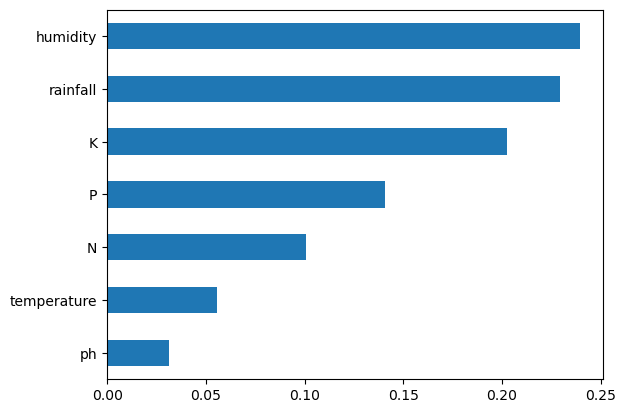

In [32]:
# Feature importance of RF model
feat_importances_rf = pd.Series(grid_rf_model.best_estimator_.feature_importances_, 
                             index = X.columns).sort_values(ascending = True)
feat_importances_rf.plot(kind = 'barh')

And here are the results for XGBoost.

In [34]:
# Hyperparameter tuning on XGBoost model
grid_values = {'max_depth': [2,3,4,5,6],
                'n_estimators' : [2,3,4,5,6]}

# Define algorithm
xgb = XGBClassifier(random_state = 1)

# Perform stratified 5-fold cross validation to get optimal hyperparameters
cross_validation = StratifiedKFold(n_splits = 5)

grid_xgb_model = GridSearchCV(xgb, param_grid = grid_values, scoring = "f1_macro", cv = cross_validation)
grid_xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = grid_xgb_model.predict(X_test)

# Print classification report on test set
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.93      1.00      0.96        13
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00         7
           9       1.00      0.89      0.94         9
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      0.89      0.94         9
          17       0.92    

The best hyperparameters, and the feature importances were printed out below.

In [35]:
# Print best estimator
grid_xgb_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=6, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

For the XGBoost, the top 3 important features are K (content of Potassium), P (content of Phosphorous), and N (content of Nitrogen). Rainfall and humidity seems to contribute as significantly to the model, as P (content of Phosphorous) & N (content of Nitrogen).

<Axes: >

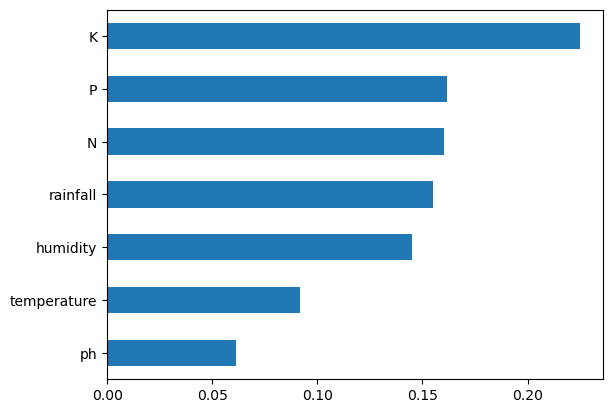

In [36]:
# Feature importance of XGBoost model
feat_importances_xgb = pd.Series(grid_xgb_model.best_estimator_.feature_importances_, 
                             index = X.columns).sort_values(ascending = True)
feat_importances_xgb.plot(kind = 'barh')

### Using the Crop Recommendation Model

Since the XGBoost performs better (in terms of accuracy, recall, and precision) in the test set, it will be the model we use for inference. 

Below, we can try out the model to recommend suitable crops. In the first example, we can use the code to obtain the best crop to plant in the given soil, whereas in the second example, we will obtain the best n plants to plant in the given soil.

In [64]:
# Input values - These values can be changed
N_val = 25
P_val = 129
K_val = 195
temperature_val = 18
humidity_val = 81
ph_val = 5
rainfall_val = 73

# Prediction code
X_to_pred = [N_val, P_val, K_val, temperature_val, humidity_val, ph_val, rainfall_val]
crop_ind = grid_xgb_model.predict([X_to_pred])
crops_recommended = list(crop_key.keys())[crop_ind[0]]

print('The best crop to plant in the given soil is {}.'.format(crops_recommended))

The best crop to plant in the given soil is grapes.


In [94]:
# Input - This value can be changed
top_n = 3

# Get top n crops
probs_dict = dict(zip(list(crop_key.keys()), grid_xgb_model.predict_proba([X_to_pred])[0]))
sorted_probs = sorted(probs_dict.items(), key = lambda x: x[1], reverse = True)

crops_recommended = [k for k,v in sorted_probs[:top_n]]
print('The best {} crop(s) to plant in the given soil is: {}.'.format(top_n, crops_recommended))

The best 3 crop(s) to plant in the given soil is: ['grapes', 'pigeonpeas', 'mothbeans']


## ML Model Training on Intelligent Irrigation System Dataset

Now, we'll be preforming model training on an automatic irrigation system dataset;

In [98]:
# Set X and y features
y = df_irr['pump']
X = df_irr.drop(['pump', 'crop'], axis = 1)

In [99]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

In [100]:
# Preprocessing
X_train = X_train.values
X_test = X_test.values

We will start by training a ridge regression model (logistic regression with L2 regularization).

In [101]:
# Hyperparameter tuning on Logistic Regression model
grid_values = {'C':[0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l2']}

# Define algorithm
Log_model = LogisticRegression(max_iter = 100, random_state = 1)

# Perform stratified 5-fold cross validation
cross_validation = StratifiedKFold(n_splits = 5)

grid_log_model = GridSearchCV(Log_model, param_grid = grid_values, scoring = 'f1_macro', cv = cross_validation)
grid_log_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = grid_log_model.predict(X_test)

# Print classification report on test set
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        62

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



It appears that for our dataset, there is a perfect separation between plants that require and do not require irrigation.

To explore this, the decision boundary is potted below.

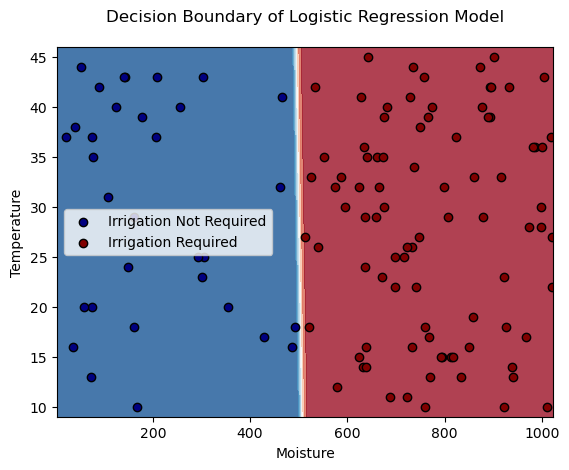

In [108]:
# Create a grid of points for X1 and X2
x1_min, x1_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
x2_min, x2_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                       np.arange(x2_min, x2_max, 0.01))

# Predict class probabilities for each point
Z = grid_log_model.predict_proba(np.c_[xx1.ravel(), xx2.ravel()])[:, 1]
Z = Z.reshape(xx1.shape)

# Start plot
plt.contourf(xx1, xx2, Z, cmap = plt.cm.RdBu_r, alpha = 0.8)
plt.xlabel('\nMoisture')
plt.ylabel('Temperature\n')

# Scatter plot for data points
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c = 'navy',
            label = 'Irrigation Not Required', edgecolor = 'k')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c = 'maroon',
            label = 'Irrigation Required', edgecolor = 'k')

# Add a legend
plt.legend()
plt.title('Decision Boundary of Logistic Regression Model\n')
plt.show()

It appears that, generally, when moisture is above 500, irrigation is required. For values closer to this threshold, the temperature also slightly affects the irrigation requirement.

In predicting the irrigation needs, moisture is the more significant feature, represented by the larger coefficient in the logistic regression model, whereas temperature is the less significant feature.

<Axes: >

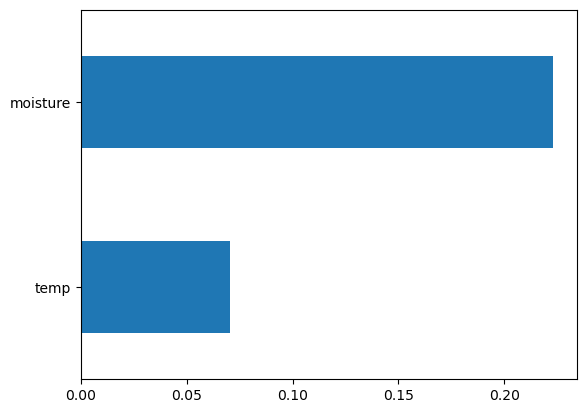

In [115]:
# Feature importance of logistic regression model
feat_importances_lr = pd.Series(grid_log_model.best_estimator_.coef_[0], 
                             index = X.columns).sort_values(ascending = True)

feat_importances_lr.plot(kind = 'barh')

### Using the Automatic Irrigation Model

Since we have achieved a perfect separation, we won't need to try out other models, and can directly use this logistic regression model for inference.

In the first example below, we are directly predicting whether irrigation is needed, whereas in the second example, we're predicting the probability whether irrigation is needed, given the input conditions.

In [120]:
# Input values - These values can be changed
moisture_vals = 503
temp_vals = 44

# Prediction
pred = grid_log_model.predict([[moisture_vals, temp_vals]])[0]
if pred == 1:
    print('Irrigation is required for the input conditions.')
else:
    print('Irrigation is not required for the input conditions.')

Irrigation is required for the input conditions.


In [126]:
# Input values - These values can be changed
moisture_vals = 503
temp_vals = 44

# Prob prediction
prob = grid_log_model.predict_proba([[moisture_vals, temp_vals]])[0][1]
print('Probability that irrigation is required for the input condition: {:.2f}%.'.format(prob*100))

Probability that irrigation is required for the input condition: 82.43%.
